In [7]:
%matplotlib widget
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os

try:
    __file__
except NameError:
    __file__ = os.path.abspath("probability_plot.ipynb")
from analysis_pkg.preprocess import *
from analysis_pkg.models import *
from analysis_pkg.visualization import *

In [15]:
def run_table(model_name, outside_field = False):
    '''model_name: "MLP", "MLPAttention" or "LogitTorch"'''
    res_all = []
    for processes in [10]:
        torch.manual_seed(2025)
        scorestb = []
        rankstb = []
        percentilestb = []
        ## load profiles and LLM expectations to profiles and df
        fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
        # combine all csv files
        df = pd.concat([pd.read_csv(f) for f in fl])
        profiles = pd.read_csv("../data/profiles_shuffled.csv")
        # ==== 3) preprocess data ====
        ## split to Xi and Xj by odd and even rows
        X = preprocess(profiles[:2000*processes])
        Xi = X[0:2000*processes:2]
        Xj = X[1:2000*processes:2]
        y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
        y = torch.from_numpy(y.values).float()
        P, d = Xi.shape
        # ==== 4) train model, and calibration ====
        split = int(0.9 * P)
        ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
        ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
        dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
        dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)
        if model_name == "MLP":
            model = MLPScorer(d_in=d, hidden=(256, 128), dropout=0.1)
        elif model_name == "MLPAttention":
            model = MLPAttentionScore(d_in=d, hidden=(256, 128), dropout=0.1, n_heads=2)
        elif model_name == "LogitTorch":
            model = LogisticRegression(d_in=d)
        model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

        ## calibrate temperature
        T = calibrate_temperature(model, dl_va)
        print(f"Calibrated Temperature T = {T:.3f}")
        # ==== 6) test on real profiles ====
        df_real = pd.read_csv("../data/real_profiles.csv")
        X_test = df_real[profiles.columns]
        X_test = preprocess_test(X_test)
        test_idx = df_real["real model"].tolist()
        if outside_field:
            sampled_out = profiles[2000*processes:].sample(n=4000*processes, random_state=2025) 
            X_out = preprocess(sampled_out)
            X_field = torch.cat([X_out, X_test], dim=0)
            fig_name = f"3d_plot_ALL_PCA_train{processes}_{model_name}.png"
        else:
            X_field = torch.cat([X, X_test], dim=0)
            fig_name = f"3d_plot_8_PCA_train{processes}_{model_name}.png"
        _, probs, scores = visualize_probability_distribution(
            model, X_field, T, num_test=X_test.shape[0], test_idx=test_idx, fig_name=fig_name, visualize=True
        )
        # print the most likely profile
        print(profiles.iloc[scores.argmax()])
        print('score: ',scores.max())
        print("\n====real profiles====\n")
        ranks = scores.argsort()[::-1]
        for p, i in zip(range(len(ranks)-8, len(ranks)), test_idx):
            rank = np.where(ranks==p)[0][0]+1
            percentile = f"{100*(len(ranks)-rank)/len(ranks):.2f}\%"
            percentilestb.append(percentile)
            rankstb.append(int(rank))
            scorestb.append(round(scores[p], 2))
            print(f"{i}'s score: {scores[p]:.2f}, rank: {rank}/{len(ranks)}, percentile: {percentile}")
        res = {'scores': scorestb, 'ranks': rankstb, 'percentiles': percentilestb, 'processes': processes}
        res_all.append(res)
    return res_all

[Epoch 01] train_loss=0.4667  val_loss=0.4095
[Epoch 02] train_loss=0.4036  val_loss=0.4027
[Epoch 03] train_loss=0.3936  val_loss=0.3982
[Epoch 04] train_loss=0.3827  val_loss=0.3912
[Epoch 05] train_loss=0.3818  val_loss=0.3979
[Epoch 06] train_loss=0.3726  val_loss=0.3891
[Epoch 07] train_loss=0.3697  val_loss=0.3908
[Epoch 08] train_loss=0.3664  val_loss=0.3993
Calibrated Temperature T = 1.073


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


battery life (in hours of video playback)        42.0
screen size (in inches)                           6.9
thickness (in mm)                                 8.8
front camera resolution (in MP)                  30.0
rear camera main lens resolution (in MP)         36.0
rear camera longest focal length (in x)           8.3
ultrawide camera                             equipped
Geekbench multicore score                      7055.0
RAM                                                 4
price                                          1149.0
Name: 38984, dtype: object
score:  1.5217607

====real profiles====

iPhone 16's score: 1.21, rank: 27/40008, percentile: 99.93\%
iPhone 16 Plus's score: 0.88, rank: 151/40008, percentile: 99.62\%
iPhone 16 Pro's score: 1.34, rank: 8/40008, percentile: 99.98\%
iPhone 16 Pro Max's score: 0.94, rank: 115/40008, percentile: 99.71\%
iPhone 17's score: 0.56, rank: 475/40008, percentile: 98.81\%
iPhone 17 Air's score: -4.14, rank: 25308/40008, percentile: 36.74\

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


battery life (in hours of video playback)        32.0
screen size (in inches)                           6.1
thickness (in mm)                                 8.8
front camera resolution (in MP)                  24.0
rear camera main lens resolution (in MP)         60.0
rear camera longest focal length (in x)           1.0
ultrawide camera                             equipped
Geekbench multicore score                      9481.0
RAM                                                 4
price                                          1249.0
Name: 10220, dtype: object
score:  4.04094

====real profiles====

iPhone 16's score: 3.59, rank: 23/40008, percentile: 99.94\%
iPhone 16 Plus's score: 3.45, rank: 48/40008, percentile: 99.88\%
iPhone 16 Pro's score: 3.80, rank: 9/40008, percentile: 99.98\%
iPhone 16 Pro Max's score: 3.08, rank: 183/40008, percentile: 99.54\%
iPhone 17's score: 3.20, rank: 125/40008, percentile: 99.69\%
iPhone 17 Air's score: -1.52, rank: 23457/40008, percentile: 41.37\%
i

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


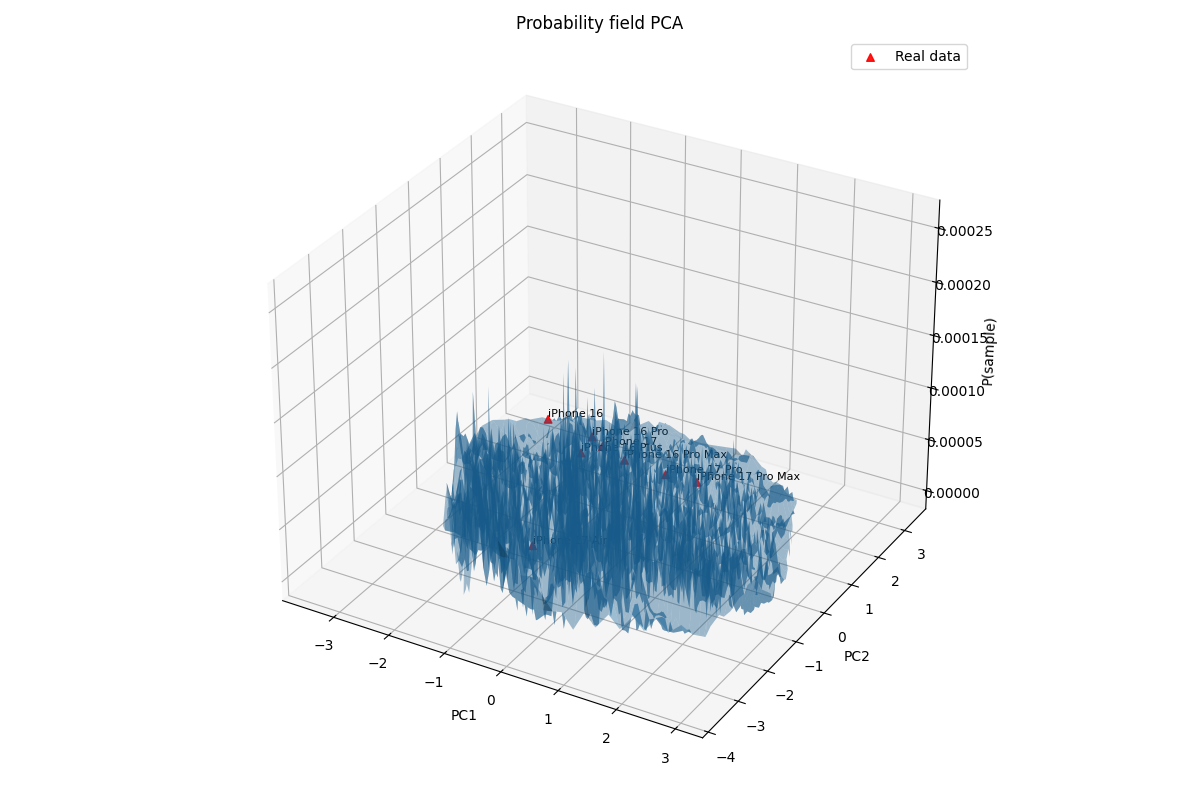

battery life (in hours of video playback)        18.0
screen size (in inches)                           6.1
thickness (in mm)                                 6.0
front camera resolution (in MP)                  24.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           8.1
ultrawide camera                             equipped
Geekbench multicore score                      9432.0
RAM                                                16
price                                           749.0
Name: 33565, dtype: object
score:  2.0974624

====real profiles====

iPhone 16's score: 1.32, rank: 640/40008, percentile: 98.40\%
iPhone 16 Plus's score: 0.89, rank: 2943/40008, percentile: 92.64\%
iPhone 16 Pro's score: 1.20, rank: 1079/40008, percentile: 97.30\%
iPhone 16 Pro Max's score: 0.76, rank: 4150/40008, percentile: 89.63\%
iPhone 17's score: 1.04, rank: 1878/40008, percentile: 95.31\%
iPhone 17 Air's score: -1.58, rank: 26808/40008, percentile:

In [ ]:
# probability field draw with 40K out of sample random profiles
MLPtb=run_table("MLP",outside_field=True)
MLPAttentiontb=run_table("MLPAttention",outside_field=True)
LogitTorchtb=run_table("LogitTorch",outside_field=True)

[Epoch 01] train_loss=0.4834  val_loss=0.4311
[Epoch 02] train_loss=0.4121  val_loss=0.4223
[Epoch 03] train_loss=0.3946  val_loss=0.4224
[Epoch 04] train_loss=0.3933  val_loss=0.4169
[Epoch 05] train_loss=0.3819  val_loss=0.4229
[Epoch 06] train_loss=0.3816  val_loss=0.4136
[Epoch 07] train_loss=0.3774  val_loss=0.4161
[Epoch 08] train_loss=0.3714  val_loss=0.4254
[Epoch 09] train_loss=0.3720  val_loss=0.4112
[Epoch 10] train_loss=0.3644  val_loss=0.4153
[Epoch 11] train_loss=0.3636  val_loss=0.4165
Calibrated Temperature T = 1.172


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


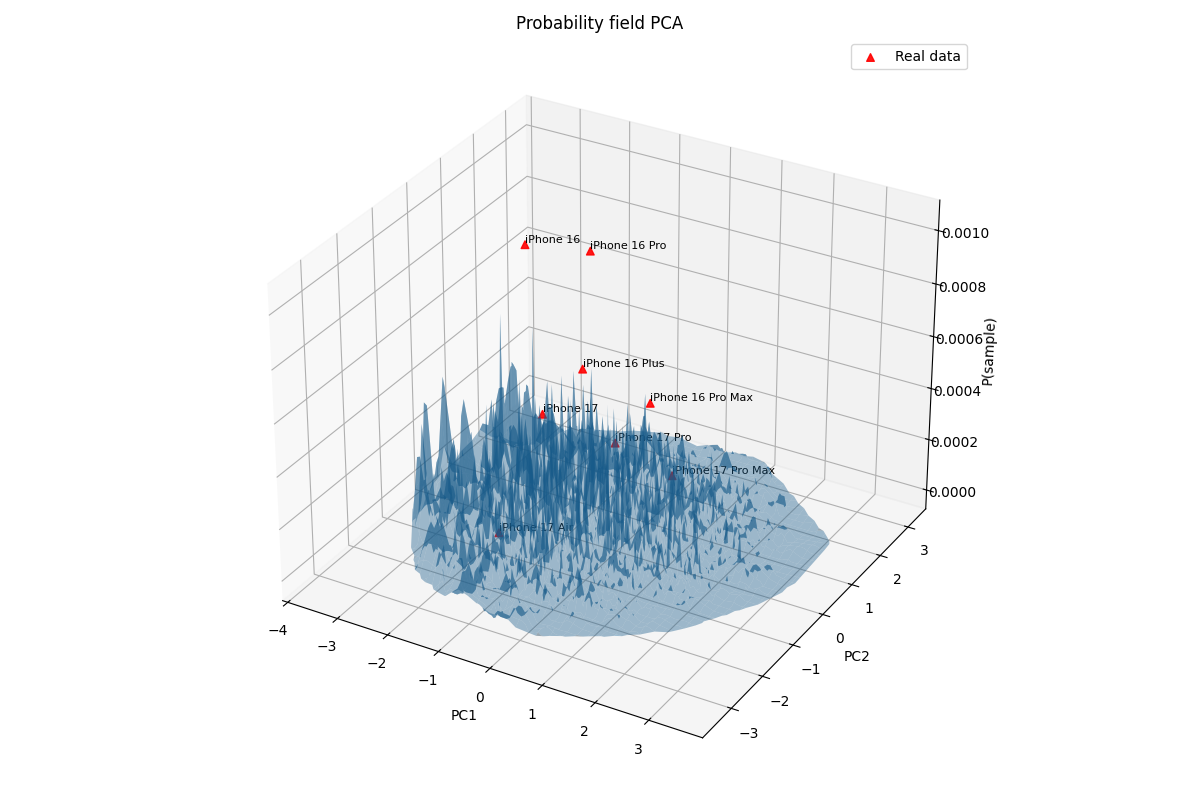

battery life (in hours of video playback)        24.0
screen size (in inches)                           6.1
thickness (in mm)                                 7.7
front camera resolution (in MP)                  12.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           3.1
ultrawide camera                             equipped
Geekbench multicore score                      8661.0
RAM                                                 8
price                                           949.0
Name: 12600, dtype: object
score:  2.010653

====real profiles====

iPhone 16's score: 1.89, rank: 3/16008, percentile: 99.98\%
iPhone 16 Plus's score: 1.23, rank: 90/16008, percentile: 99.44\%
iPhone 16 Pro's score: 1.87, rank: 7/16008, percentile: 99.96\%
iPhone 16 Pro Max's score: 0.96, rank: 193/16008, percentile: 98.79\%
iPhone 17's score: 0.88, rank: 244/16008, percentile: 98.48\%
iPhone 17 Air's score: -3.89, rank: 10543/16008, percentile: 34.14\%
i

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


battery life (in hours of video playback)        41.0
screen size (in inches)                           6.3
thickness (in mm)                                7.86
front camera resolution (in MP)                  11.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           5.0
ultrawide camera                             equipped
Geekbench multicore score                      7029.0
RAM                                                 8
price                                          1070.0
Name: 10526, dtype: object
score:  2.0186503

====real profiles====

iPhone 16's score: 1.52, rank: 15/18008, percentile: 99.92\%
iPhone 16 Plus's score: 1.19, rank: 87/18008, percentile: 99.52\%
iPhone 16 Pro's score: 1.61, rank: 11/18008, percentile: 99.94\%
iPhone 16 Pro Max's score: 1.12, rank: 120/18008, percentile: 99.33\%
iPhone 17's score: 0.93, rank: 232/18008, percentile: 98.71\%
iPhone 17 Air's score: -3.63, rank: 11455/18008, percentile: 36.39\

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


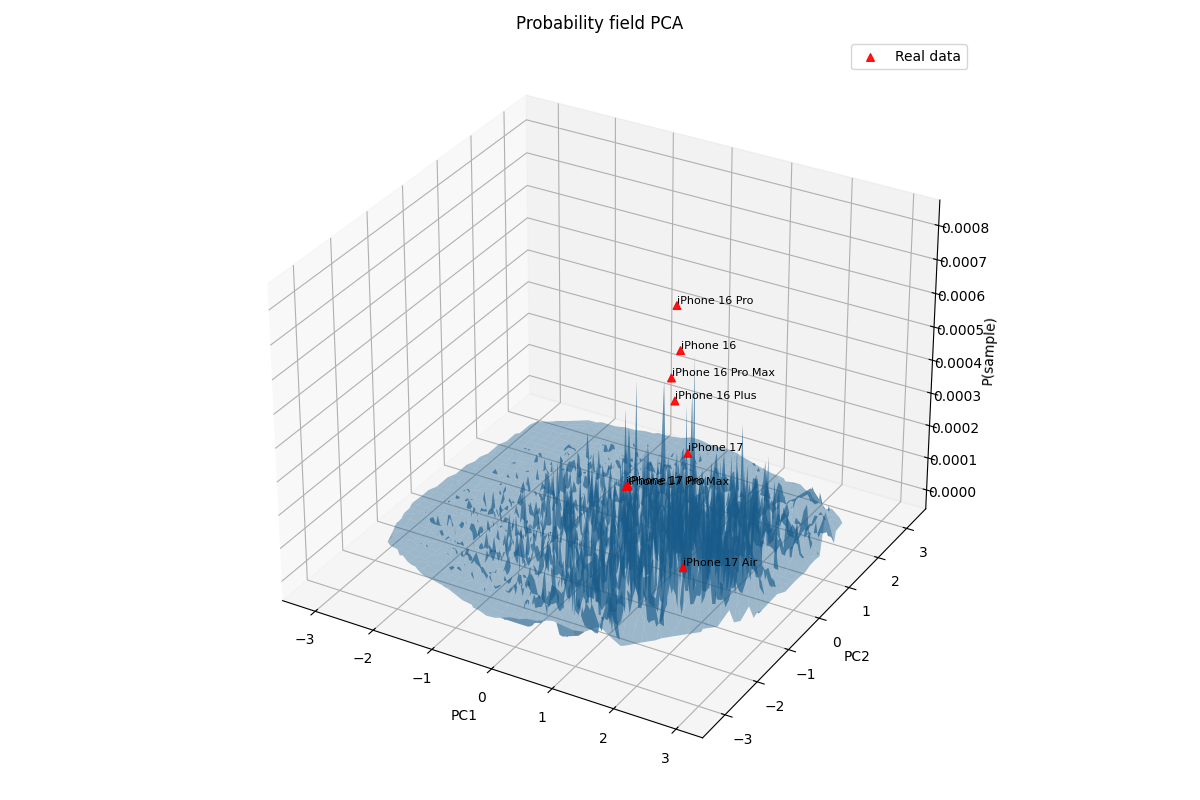

battery life (in hours of video playback)        41.0
screen size (in inches)                           6.3
thickness (in mm)                                7.86
front camera resolution (in MP)                  11.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           5.0
ultrawide camera                             equipped
Geekbench multicore score                      7029.0
RAM                                                 8
price                                          1070.0
Name: 10526, dtype: object
score:  1.4874153

====real profiles====

iPhone 16's score: 1.21, rank: 14/20008, percentile: 99.93\%
iPhone 16 Plus's score: 0.88, rank: 61/20008, percentile: 99.70\%
iPhone 16 Pro's score: 1.34, rank: 7/20008, percentile: 99.97\%
iPhone 16 Pro Max's score: 0.94, rank: 40/20008, percentile: 99.80\%
iPhone 17's score: 0.56, rank: 242/20008, percentile: 98.79\%
iPhone 17 Air's score: -4.14, rank: 12690/20008, percentile: 36.58\%


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


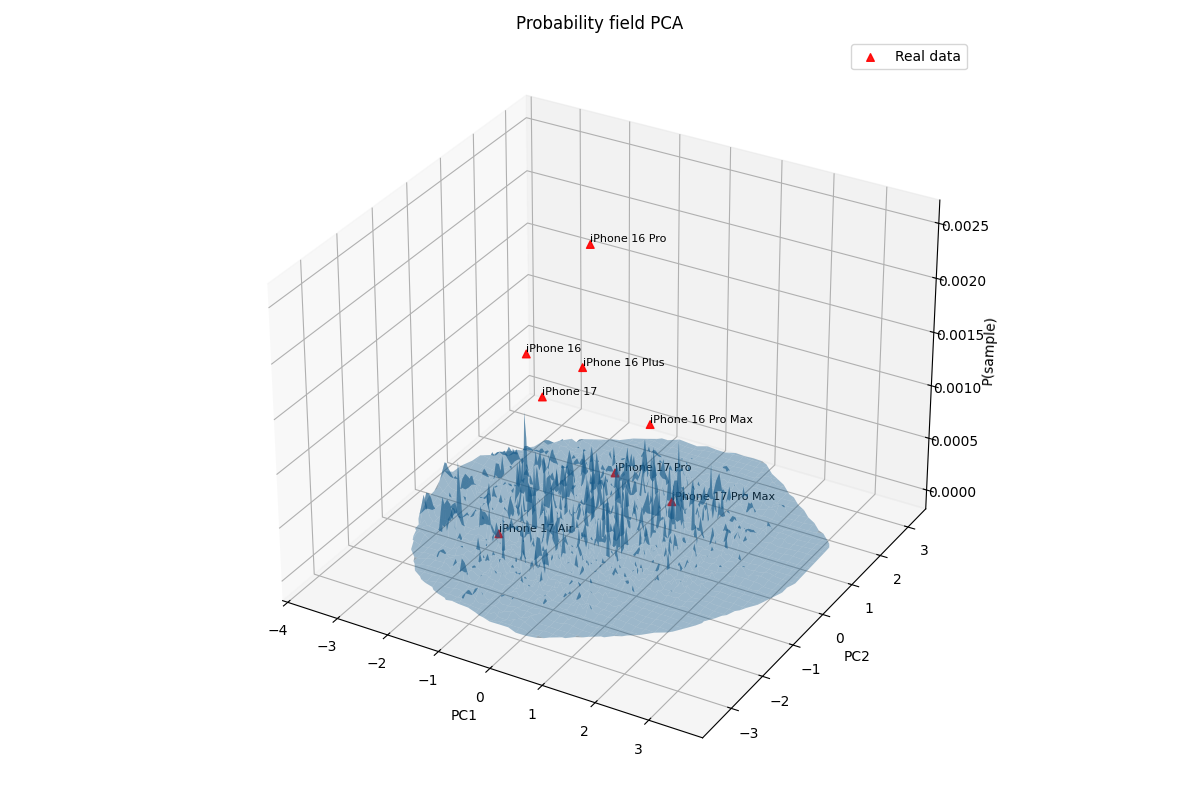

battery life (in hours of video playback)        30.0
screen size (in inches)                           6.3
thickness (in mm)                                 7.7
front camera resolution (in MP)                  13.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           5.2
ultrawide camera                             equipped
Geekbench multicore score                      8600.0
RAM                                                 8
price                                          1054.0
Name: 14940, dtype: object
score:  6.02462

====real profiles====

iPhone 16's score: 5.22, rank: 20/16008, percentile: 99.88\%
iPhone 16 Plus's score: 5.16, rank: 23/16008, percentile: 99.86\%
iPhone 16 Pro's score: 5.80, rank: 3/16008, percentile: 99.98\%
iPhone 16 Pro Max's score: 4.65, rank: 63/16008, percentile: 99.61\%
iPhone 17's score: 4.96, rank: 33/16008, percentile: 99.79\%
iPhone 17 Air's score: -0.90, rank: 9709/16008, percentile: 39.35\%
iPho

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


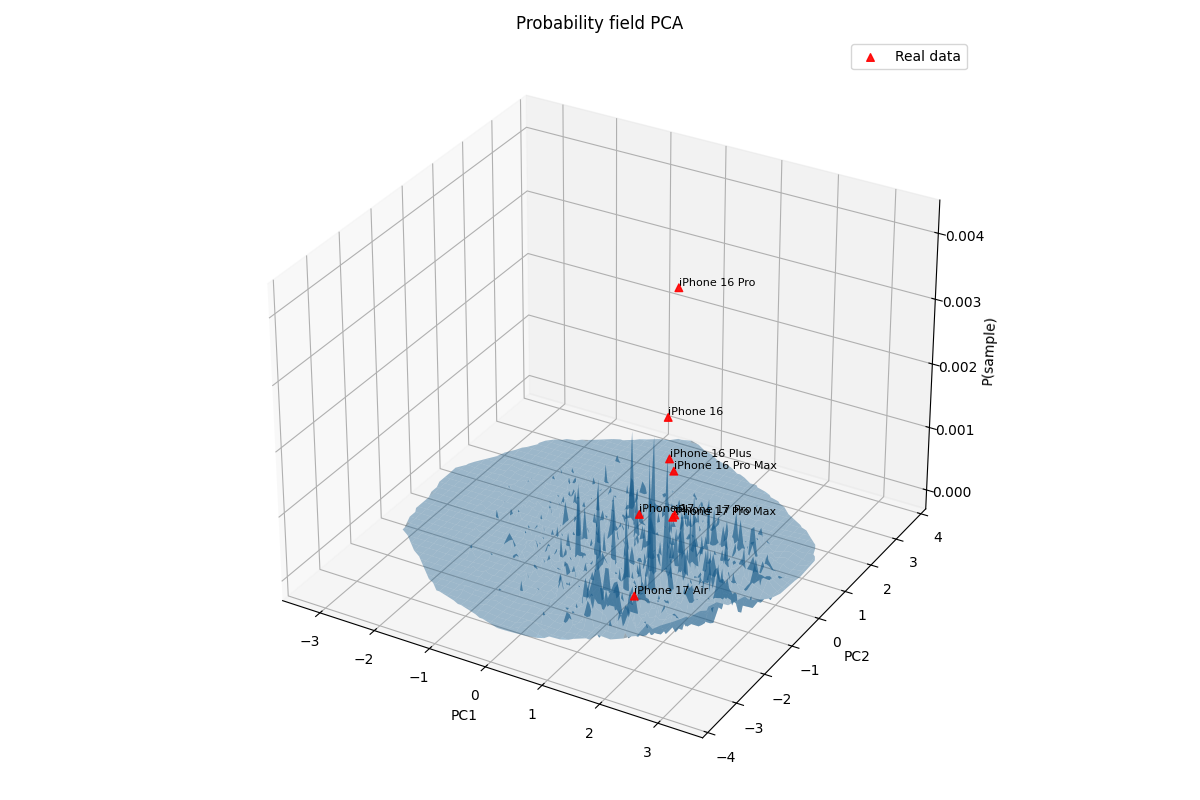

battery life (in hours of video playback)        30.0
screen size (in inches)                           6.3
thickness (in mm)                                 7.7
front camera resolution (in MP)                  13.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           5.2
ultrawide camera                             equipped
Geekbench multicore score                      8600.0
RAM                                                 8
price                                          1054.0
Name: 14940, dtype: object
score:  6.751449

====real profiles====

iPhone 16's score: 6.14, rank: 12/18008, percentile: 99.93\%
iPhone 16 Plus's score: 5.72, rank: 38/18008, percentile: 99.79\%
iPhone 16 Pro's score: 6.57, rank: 3/18008, percentile: 99.98\%
iPhone 16 Pro Max's score: 5.30, rank: 113/18008, percentile: 99.37\%
iPhone 17's score: 5.32, rank: 108/18008, percentile: 99.40\%
iPhone 17 Air's score: -1.10, rank: 12274/18008, percentile: 31.84\%


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


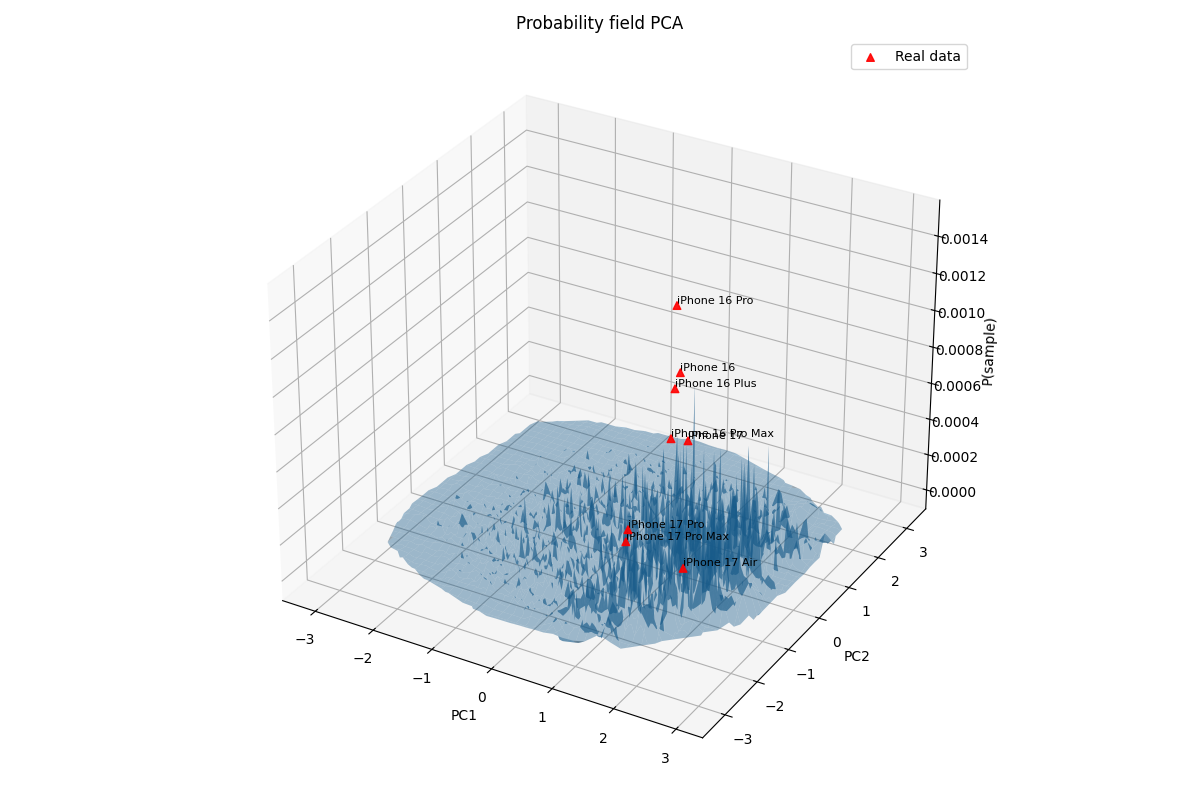

battery life (in hours of video playback)        24.0
screen size (in inches)                           6.1
thickness (in mm)                                 7.7
front camera resolution (in MP)                  12.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           3.1
ultrawide camera                             equipped
Geekbench multicore score                      8661.0
RAM                                                 8
price                                           949.0
Name: 12600, dtype: object
score:  3.9737756

====real profiles====

iPhone 16's score: 3.59, rank: 13/20008, percentile: 99.94\%
iPhone 16 Plus's score: 3.45, rank: 22/20008, percentile: 99.89\%
iPhone 16 Pro's score: 3.80, rank: 5/20008, percentile: 99.98\%
iPhone 16 Pro Max's score: 3.08, rank: 81/20008, percentile: 99.60\%
iPhone 17's score: 3.20, rank: 52/20008, percentile: 99.74\%
iPhone 17 Air's score: -1.52, rank: 11800/20008, percentile: 41.02\%
i

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


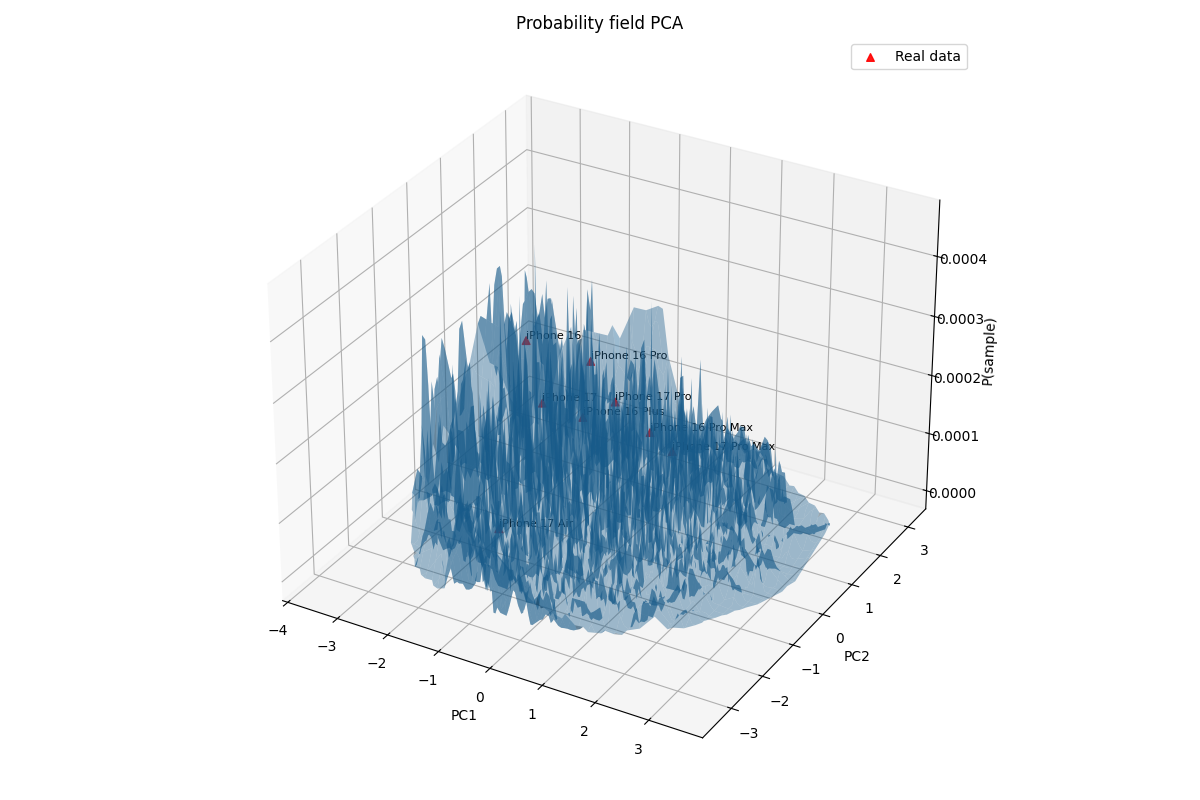

battery life (in hours of video playback)        18.0
screen size (in inches)                           6.1
thickness (in mm)                                 8.8
front camera resolution (in MP)                  11.0
rear camera main lens resolution (in MP)         36.0
rear camera longest focal length (in x)           3.0
ultrawide camera                             equipped
Geekbench multicore score                      8600.0
RAM                                                 4
price                                           959.0
Name: 15941, dtype: object
score:  1.8068669

====real profiles====

iPhone 16's score: 1.24, rank: 273/16008, percentile: 98.29\%
iPhone 16 Plus's score: 0.83, rank: 1329/16008, percentile: 91.70\%
iPhone 16 Pro's score: 1.14, rank: 416/16008, percentile: 97.40\%
iPhone 16 Pro Max's score: 0.72, rank: 1784/16008, percentile: 88.86\%
iPhone 17's score: 0.96, rank: 871/16008, percentile: 94.56\%
iPhone 17 Air's score: -1.35, rank: 10765/16008, percentile: 3

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


battery life (in hours of video playback)        18.0
screen size (in inches)                           6.1
thickness (in mm)                                 8.8
front camera resolution (in MP)                  11.0
rear camera main lens resolution (in MP)         36.0
rear camera longest focal length (in x)           3.0
ultrawide camera                             equipped
Geekbench multicore score                      8600.0
RAM                                                 4
price                                           959.0
Name: 15941, dtype: object
score:  1.8612919

====real profiles====

iPhone 16's score: 1.29, rank: 287/18008, percentile: 98.41\%
iPhone 16 Plus's score: 0.85, rank: 1472/18008, percentile: 91.83\%
iPhone 16 Pro's score: 1.18, rank: 455/18008, percentile: 97.47\%
iPhone 16 Pro Max's score: 0.73, rank: 2023/18008, percentile: 88.77\%
iPhone 17's score: 1.00, rank: 919/18008, percentile: 94.90\%
iPhone 17 Air's score: -1.46, rank: 12015/18008, percentile: 3

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


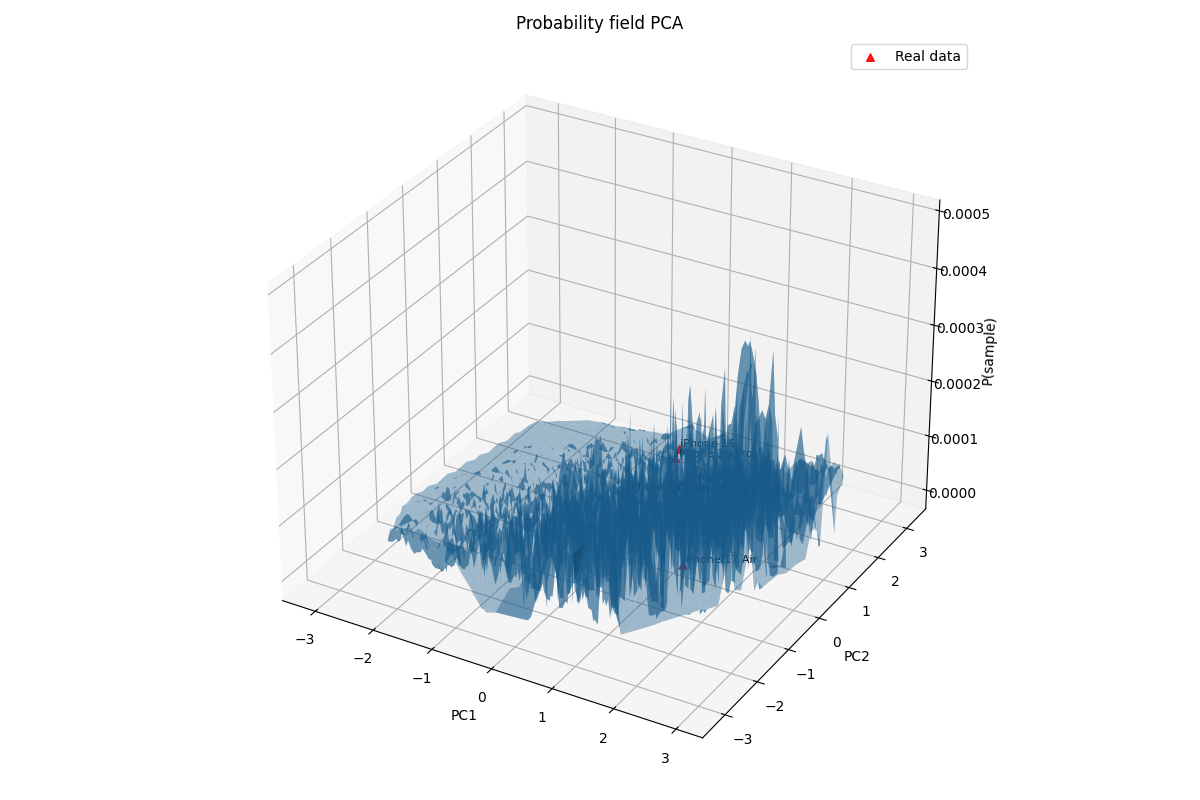

battery life (in hours of video playback)        18.0
screen size (in inches)                           6.1
thickness (in mm)                                 8.8
front camera resolution (in MP)                  11.0
rear camera main lens resolution (in MP)         36.0
rear camera longest focal length (in x)           3.0
ultrawide camera                             equipped
Geekbench multicore score                      8600.0
RAM                                                 4
price                                           959.0
Name: 15941, dtype: object
score:  1.9200605

====real profiles====

iPhone 16's score: 1.32, rank: 320/20008, percentile: 98.40\%
iPhone 16 Plus's score: 0.89, rank: 1533/20008, percentile: 92.34\%
iPhone 16 Pro's score: 1.20, rank: 525/20008, percentile: 97.38\%
iPhone 16 Pro Max's score: 0.76, rank: 2165/20008, percentile: 89.18\%
iPhone 17's score: 1.04, rank: 958/20008, percentile: 95.21\%
iPhone 17 Air's score: -1.58, rank: 13457/20008, percentile: 3

In [ ]:
# probability field draw with 20K training profiles
MLPtb=run_table("MLP")
MLPAttentiontb=run_table("MLPAttention")
LogitTorchtb=run_table("LogitTorch")

In [18]:
df_real = pd.read_csv("../data/real_profiles.csv")
for i in range(8):
    print(df_real['real model'][i], end=' & ')
    for j in ['ranks','percentiles']:
        print(MLPtb[0][j][i], end=' & ')
    for j in ['ranks','percentiles']:
        print(MLPAttentiontb[0][j][i], end=' & ')
    for j in ['ranks','percentiles']:
        print(LogitTorchtb[0][j][i], end=' & ' if j=='ranks' else ' \\\\ \n')

iPhone 16 & 27 & 99.93\% & 23 & 99.94\% & 640 & 98.40\% \\ 
iPhone 16 Plus & 151 & 99.62\% & 48 & 99.88\% & 2943 & 92.64\% \\ 
iPhone 16 Pro & 8 & 99.98\% & 9 & 99.98\% & 1079 & 97.30\% \\ 
iPhone 16 Pro Max & 115 & 99.71\% & 183 & 99.54\% & 4150 & 89.63\% \\ 
iPhone 17 & 475 & 98.81\% & 125 & 99.69\% & 1878 & 95.31\% \\ 
iPhone 17 Air & 25308 & 36.74\% & 23457 & 41.37\% & 26808 & 32.99\% \\ 
iPhone 17 Pro & 1333 & 96.67\% & 1634 & 95.92\% & 3048 & 92.38\% \\ 
iPhone 17 Pro Max & 2032 & 94.92\% & 5287 & 86.79\% & 7801 & 80.50\% \\ 


In [13]:
df_real = pd.read_csv("../data/real_profiles.csv")
tb = 'percentiles'
for i in range(8):
    print(df_real['real model'][i], end=' & ')
    for k in range(3):
        print(MLPtb[k][tb][i], end=' & ')
    for k in range(3):
        print(MLPAttentiontb[k][tb][i], end=' & ' if k<2 else ' \\\\ \n')
    # for j in ['ranks','percentiles']:
    #     print(LogitTorchtb[2][j][i], end=' & ' if j=='ranks' else ' \\\\ \n')

iPhone 16 & 99.98\% & 99.92\% & 99.93\% & 99.88\% & 99.93\% & 99.94\% \\ 
iPhone 16 Plus & 99.44\% & 99.52\% & 99.70\% & 99.86\% & 99.79\% & 99.89\% \\ 
iPhone 16 Pro & 99.96\% & 99.94\% & 99.97\% & 99.98\% & 99.98\% & 99.98\% \\ 
iPhone 16 Pro Max & 98.79\% & 99.33\% & 99.80\% & 99.61\% & 99.37\% & 99.60\% \\ 
iPhone 17 & 98.48\% & 98.71\% & 98.79\% & 99.79\% & 99.40\% & 99.74\% \\ 
iPhone 17 Air & 34.14\% & 36.39\% & 36.58\% & 39.35\% & 31.84\% & 41.02\% \\ 
iPhone 17 Pro & 94.55\% & 94.71\% & 96.63\% & 96.14\% & 97.56\% & 95.57\% \\ 
iPhone 17 Pro Max & 87.42\% & 92.18\% & 94.82\% & 86.14\% & 83.49\% & 86.40\% \\ 
